## Final Project - Group 1 - AAI 530
### Zach Artman, Iman Hamdan, Diego Aceveda

In [1]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from sklearn.ensemble import IsolationForest
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

## Data Exploration

In [2]:
# Downloading the dataset
path = kagglehub.dataset_download("hemanthkarnati/indoor-air-quality-dataset")
dataset_path = f"{path}/indoor_data.csv"

In [30]:
dataset_path

'/Users/zacharyartman/.cache/kagglehub/datasets/hemanthkarnati/indoor-air-quality-dataset/versions/1/indoor_data.csv'

In [3]:
# Read the dataset
df = pd.read_csv(dataset_path)

# Explore the first few entries of the dataset
df.head()

,created_at,entry_id,field1,field2,field3,field4,field5,field6,field7,latitude,longitude,elevation,status
0,2024-04-06 12:00:27+05:30,1256,163,42.0,33.8,49.0,520.0,18.0,21.0,NaN,NaN,NaN,NaN
1,2024-04-06 12:01:30+05:30,1257,162,37.0,33.8,49.0,637.0,36.0,9.0,NaN,NaN,NaN,NaN
2,2024-04-06 12:02:32+05:30,1258,173,47.0,33.7,50.0,679.0,42.0,3.0,NaN,NaN,NaN,NaN
3,2024-04-06 12:03:34+05:30,1259,168,37.0,33.3,51.0,539.0,21.0,0.0,NaN,NaN,NaN,NaN
4,2024-04-06 12:04:36+05:30,1260,168,37.0,33.3,52.0,697.0,45.0,0.0,NaN,NaN,NaN,NaN


In [4]:
# Explore the last few entries of the dataset
df.tail()

,created_at,entry_id,field1,field2,field3,field4,field5,field6,field7,latitude,longitude,elevation,status
1328,2024-04-07 11:54:43+05:30,2584,195,46.0,32.8,51.0,493.0,14.0,0.0,NaN,NaN,NaN,NaN
1329,2024-04-07 11:55:45+05:30,2585,198,40.0,32.8,50.0,539.0,21.0,0.0,NaN,NaN,NaN,NaN
1330,2024-04-07 11:56:47+05:30,2586,191,39.0,32.8,50.0,464.0,9.0,432.0,NaN,NaN,NaN,NaN
1331,2024-04-07 11:58:44+05:30,2587,191,43.0,32.8,49.0,454.0,8.0,0.0,NaN,NaN,NaN,NaN
1332,2024-04-07 11:59:46+05:30,2588,191,39.0,32.8,49.0,493.0,14.0,0.0,NaN,NaN,NaN,NaN


Dataset shows data roughly every minute from April 6, 2024 at 12:00 to April 7, 2024 at 11:59

## Preprocessing

In [5]:
# Drop the columns that have all NaN values
columns_to_drop = ['latitude', 'longitude', 'elevation', 'status']
df.drop(columns_to_drop, axis=1, inplace=True)

In [6]:
# Assert the columns were dropped
df.head()

,created_at,entry_id,field1,field2,field3,field4,field5,field6,field7
0,2024-04-06 12:00:27+05:30,1256,163,42.0,33.8,49.0,520.0,18.0,21.0
1,2024-04-06 12:01:30+05:30,1257,162,37.0,33.8,49.0,637.0,36.0,9.0
2,2024-04-06 12:02:32+05:30,1258,173,47.0,33.7,50.0,679.0,42.0,3.0
3,2024-04-06 12:03:34+05:30,1259,168,37.0,33.3,51.0,539.0,21.0,0.0
4,2024-04-06 12:04:36+05:30,1260,168,37.0,33.3,52.0,697.0,45.0,0.0


In [7]:
# Checking the datatypes
df.dtypes

created_at     object
entry_id        int64
field1          int64
field2        float64
field3        float64
field4        float64
field5        float64
field6        float64
field7        float64
dtype: object

Fixing the remaining datatypes

In [8]:
# Convert the created_at column to a datetime object
df['Datetime'] = pd.to_datetime(df['created_at'])
df.drop('created_at', axis=1, inplace=True)

In [9]:
df.head()

,entry_id,field1,field2,field3,field4,field5,field6,field7,Datetime
0,1256,163,42.0,33.8,49.0,520.0,18.0,21.0,2024-04-06 12:00:27+05:30
1,1257,162,37.0,33.8,49.0,637.0,36.0,9.0,2024-04-06 12:01:30+05:30
2,1258,173,47.0,33.7,50.0,679.0,42.0,3.0,2024-04-06 12:02:32+05:30
3,1259,168,37.0,33.3,51.0,539.0,21.0,0.0,2024-04-06 12:03:34+05:30
4,1260,168,37.0,33.3,52.0,697.0,45.0,0.0,2024-04-06 12:04:36+05:30


In [10]:
# Asserting that the created column is the proper type
df.dtypes

entry_id                        int64
field1                          int64
field2                        float64
field3                        float64
field4                        float64
field5                        float64
field6                        float64
field7                        float64
Datetime    datetime64[ns, UTC+05:30]
dtype: object

In [11]:
# Create a minute column defining how many minutes has passed
df['minute'] = pd.to_datetime(df['Datetime'])
df['minute'] = (df['minute'] - df['minute'][0]).dt.total_seconds() // 60

Checking the data

In [12]:
df.head()

,entry_id,field1,field2,field3,field4,field5,field6,field7,Datetime,minute
0,1256,163,42.0,33.8,49.0,520.0,18.0,21.0,2024-04-06 12:00:27+05:30,0.0
1,1257,162,37.0,33.8,49.0,637.0,36.0,9.0,2024-04-06 12:01:30+05:30,1.0
2,1258,173,47.0,33.7,50.0,679.0,42.0,3.0,2024-04-06 12:02:32+05:30,2.0
3,1259,168,37.0,33.3,51.0,539.0,21.0,0.0,2024-04-06 12:03:34+05:30,3.0
4,1260,168,37.0,33.3,52.0,697.0,45.0,0.0,2024-04-06 12:04:36+05:30,4.0


In [13]:
df.tail()

,entry_id,field1,field2,field3,field4,field5,field6,field7,Datetime,minute
1328,2584,195,46.0,32.8,51.0,493.0,14.0,0.0,2024-04-07 11:54:43+05:30,1434.0
1329,2585,198,40.0,32.8,50.0,539.0,21.0,0.0,2024-04-07 11:55:45+05:30,1435.0
1330,2586,191,39.0,32.8,50.0,464.0,9.0,432.0,2024-04-07 11:56:47+05:30,1436.0
1331,2587,191,43.0,32.8,49.0,454.0,8.0,0.0,2024-04-07 11:58:44+05:30,1438.0
1332,2588,191,39.0,32.8,49.0,493.0,14.0,0.0,2024-04-07 11:59:46+05:30,1439.0


In [14]:
# Rename the columns based on the actual values
df.rename(columns={
    'field1': 'CO_ppm',
    'field2': 'AirQuality',
    'field3': 'Temperature',
    'field4': 'Humidity',
    'field5': 'eCO2_ppm',
    'field6': 'TVOC_ppb',
    'field7': 'DustDensity_ugm3'
}, inplace=True)
df.head()

,entry_id,CO_ppm,AirQuality,Temperature,Humidity,eCO2_ppm,TVOC_ppb,DustDensity_ugm3,Datetime,minute
0,1256,163,42.0,33.8,49.0,520.0,18.0,21.0,2024-04-06 12:00:27+05:30,0.0
1,1257,162,37.0,33.8,49.0,637.0,36.0,9.0,2024-04-06 12:01:30+05:30,1.0
2,1258,173,47.0,33.7,50.0,679.0,42.0,3.0,2024-04-06 12:02:32+05:30,2.0
3,1259,168,37.0,33.3,51.0,539.0,21.0,0.0,2024-04-06 12:03:34+05:30,3.0
4,1260,168,37.0,33.3,52.0,697.0,45.0,0.0,2024-04-06 12:04:36+05:30,4.0


In [15]:
# Checking for missing values
missing_values = df.isnull().sum()

missing_values


entry_id            0
CO_ppm              0
AirQuality          0
Temperature         0
Humidity            0
eCO2_ppm            0
TVOC_ppb            0
DustDensity_ugm3    0
Datetime            0
minute              0
dtype: int64

## Visualizing The Data

<Figure size 1200x600 with 0 Axes>

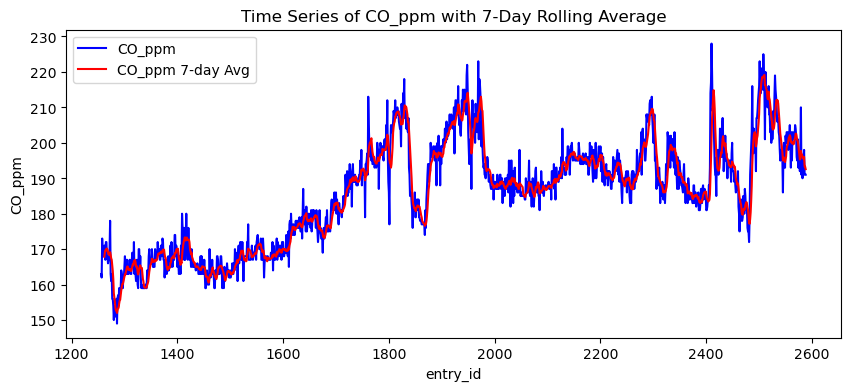

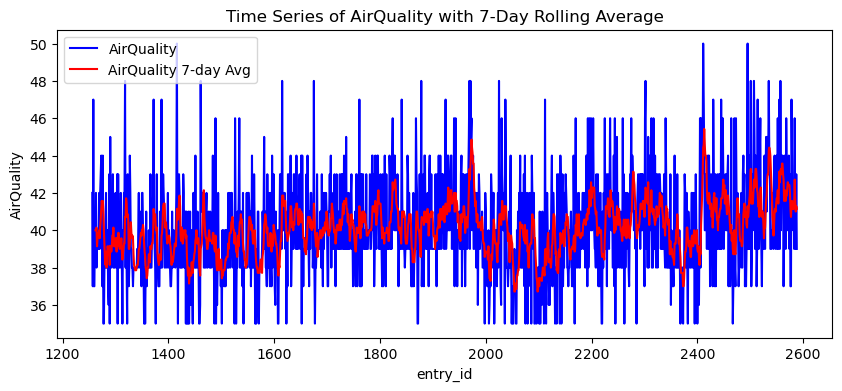

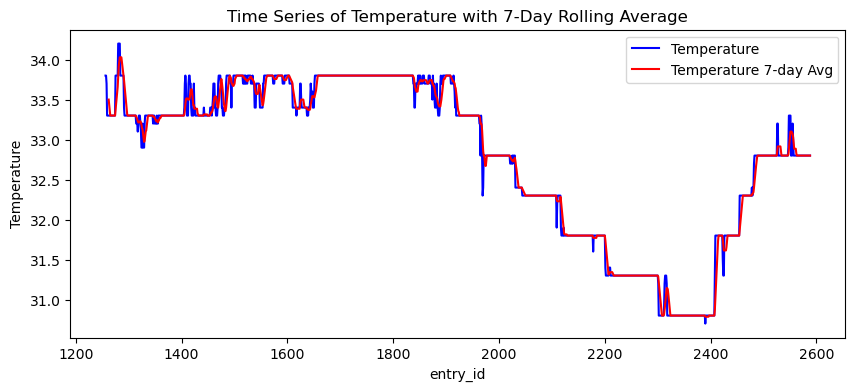

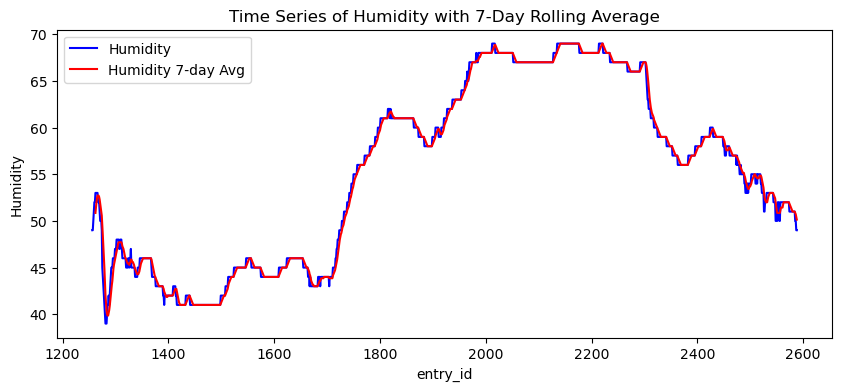

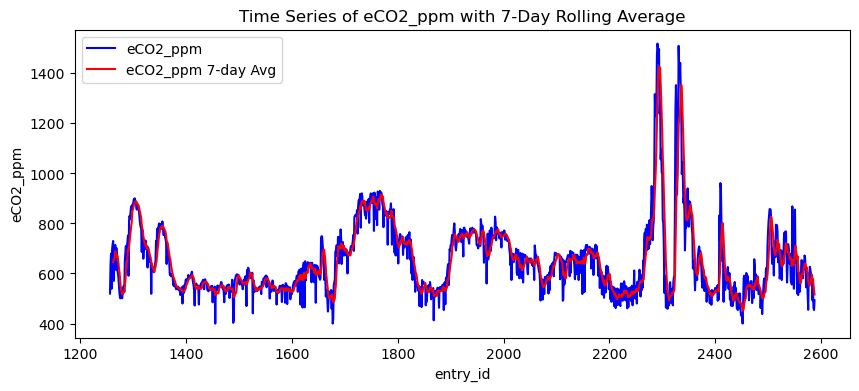

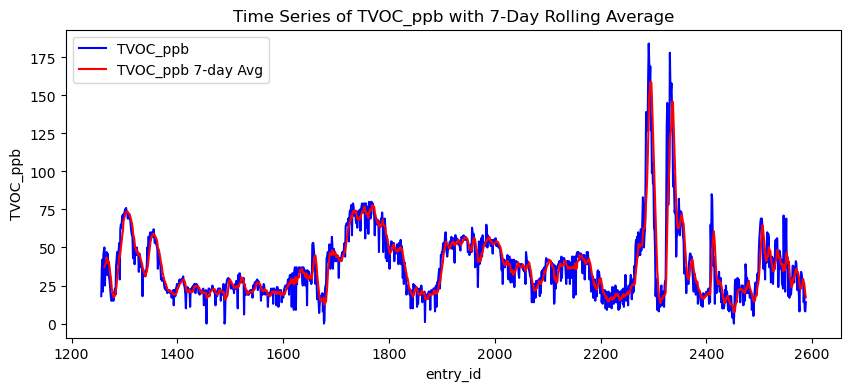

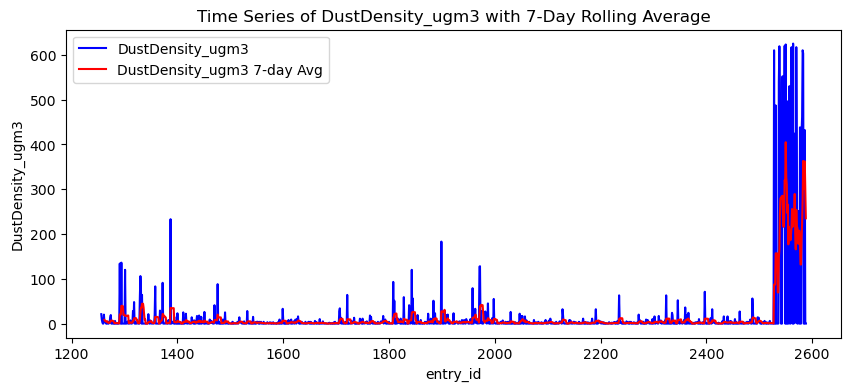

In [16]:
# Using rolling averages
rolling_window = 7

plt.figure(figsize=(12,6))
time_col = df.columns[0]

for col in df.columns[1:-2]:  
    plt.figure(figsize=(10,4))
    plt.plot(df[time_col], df[col], label=f'{col}', color='b')
    plt.plot(df[time_col], df[col].rolling(window=rolling_window).mean(), label=f'{col} {rolling_window}-day Avg', color='r')
    plt.xlabel(time_col)
    plt.ylabel(col)
    plt.title(f'Time Series of {col} with {rolling_window}-Day Rolling Average')
    plt.legend()
    plt.show()

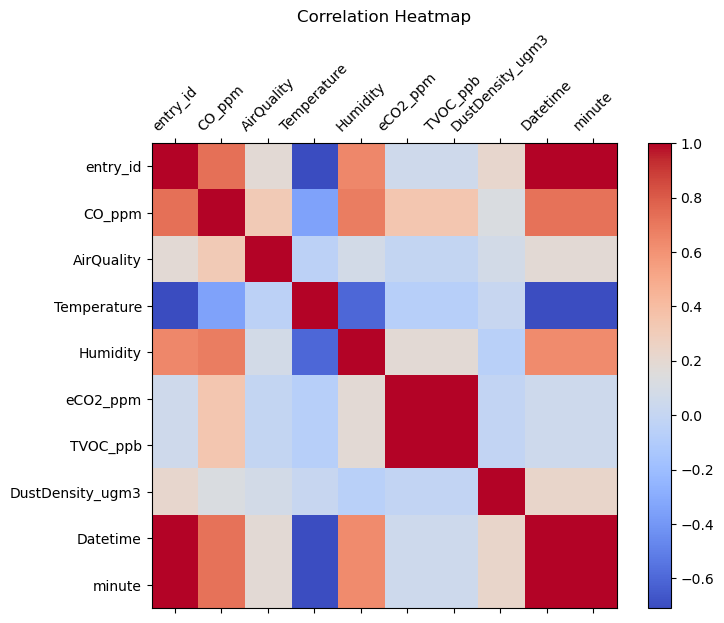

In [17]:
corr_matrix = df.corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
plt.matshow(corr_matrix, cmap='coolwarm', fignum=1)
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Correlation Heatmap')
plt.show()

# Model 1

The Elbow Method plot provides a visual guide for determining the optimal number of clusters (k) for our K-Means analysis.  By examining the plot, we can identify the "elbow" point, which represents the value of k where increasing the number of clusters provides diminishing returns in terms of reducing within-cluster variance.  This point suggests a balance between capturing the underlying data structure and avoiding overfitting.  Once we've identified the optimal k from the graph, we can confidently proceed with the K-Means clustering algorithm.

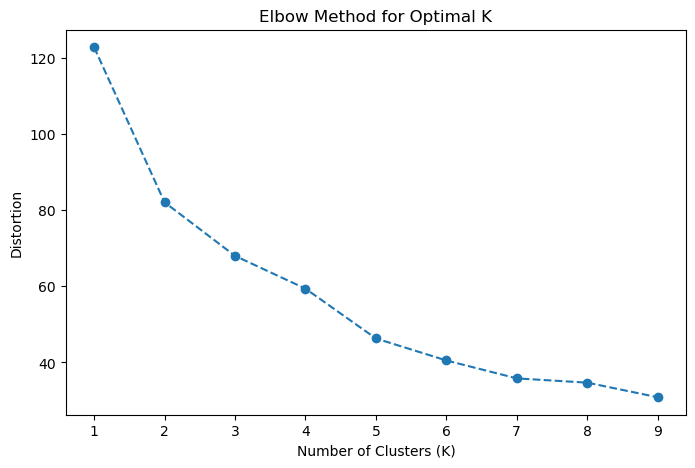

In [18]:
# Selecting relevant features for clustering
features = ['CO_ppm', 'AirQuality', 'Temperature', 'Humidity', 'eCO2_ppm', 'TVOC_ppb', 'DustDensity_ugm3']
X = df[features]

# Finding the optimal number of clusters using the Elbow Method
distortions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plotting the Elbow Method result
plt.figure(figsize=(8, 5))
plt.plot(K, distortions, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal K')
plt.show()

For our clustering analysis, we explored two different approaches.  First, we used K-Means, which aims to partition the data into a pre-defined number of clusters.  In our case, the Elbow Method suggested three clusters as an optimal balance between minimizing within-cluster variance and avoiding overfitting.  It's important to remember that K-Means works best when the clusters are relatively spherical and well-separated – think distinct groups.

We also employed DBSCAN, which takes a different tack.  Instead of assuming a fixed number of clusters, DBSCAN identifies clusters based on data point density.  A key advantage of DBSCAN is its ability to handle irregularly shaped clusters and, importantly, identify noise or outlier points. These outliers, often labeled as -1, represent data points that don't neatly fall into any defined cluster.  This makes DBSCAN a valuable tool for anomaly detection alongside its clustering capabilities.

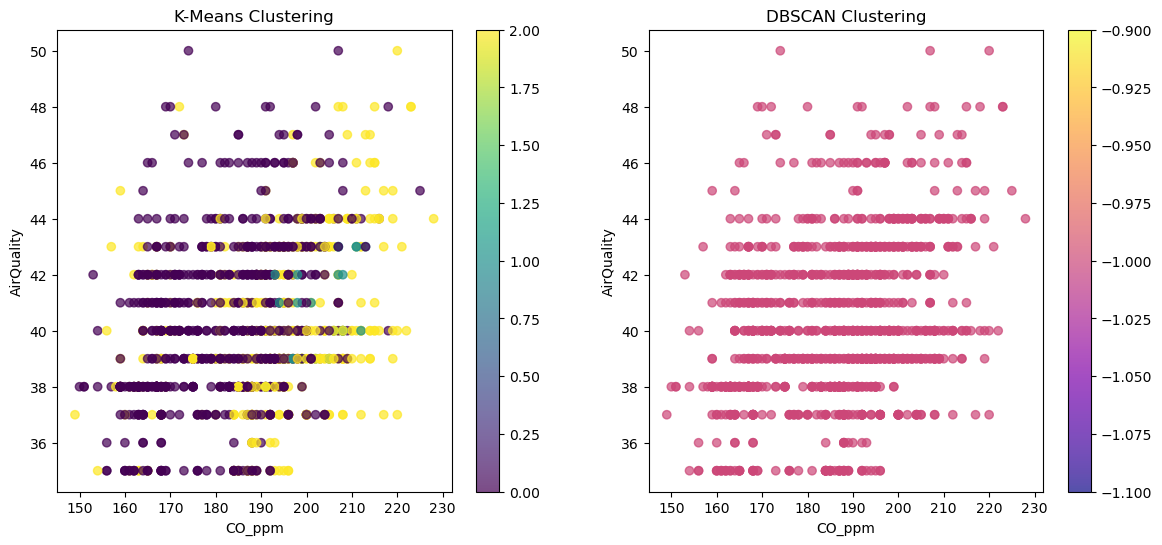

In [19]:
# Applying K-Means with optimal K (choosing based on elbow method)
optimal_k = 3  # Adjust if needed based on the plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['KMeans_Cluster'] = kmeans.fit_predict(X)

# Applying DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=10)  # Adjusting parameters for better grouping
df['DBSCAN_Cluster'] = dbscan.fit_predict(X)

# Visualizing the clustering results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# K-Means clustering visualization
scatter1 = axes[0].scatter(df['CO_ppm'], df['AirQuality'], c=df['KMeans_Cluster'], cmap='viridis', alpha=0.7)
axes[0].set_xlabel('CO_ppm')
axes[0].set_ylabel('AirQuality')
axes[0].set_title('K-Means Clustering')
plt.colorbar(scatter1, ax=axes[0])

# DBSCAN clustering visualization
scatter2 = axes[1].scatter(df['CO_ppm'], df['AirQuality'], c=df['DBSCAN_Cluster'], cmap='plasma', alpha=0.7)
axes[1].set_xlabel('CO_ppm')
axes[1].set_ylabel('AirQuality')
axes[1].set_title('DBSCAN Clustering')
plt.colorbar(scatter2, ax=axes[1])

plt.show()

### Isolation Forest

The Isolation Forest model has identified potential outliers within the air quality dataset.  These outliers, visualized as red points, represent anomalous readings that deviate significantly from the expected data distribution.  Conversely, blue points represent data conforming to typical patterns.

This analysis serves to detect abrupt fluctuations in both carbon monoxide (CO) levels and overall Air Quality Index (AQI) values.  The identification of such anomalies is crucial for distinguishing between genuine environmental events, such as pollution spikes, and potential sensor malfunctions requiring technical attention.  This distinction enables more accurate environmental monitoring and facilitates timely intervention when necessary.

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


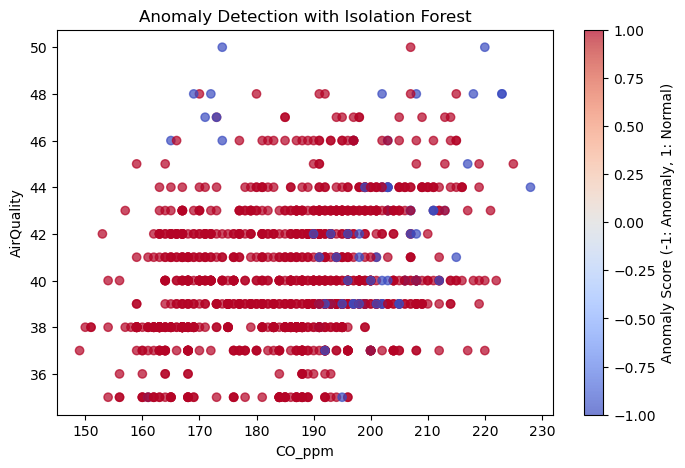

In [20]:
# Applying Isolation Forest for anomaly detection
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df['Anomaly_Score'] = iso_forest.fit_predict(X)

# Visualizing anomalies
plt.figure(figsize=(8, 5))
scatter = plt.scatter(df['CO_ppm'], df['AirQuality'], c=df['Anomaly_Score'], cmap='coolwarm', alpha=0.7)
plt.xlabel('CO_ppm')
plt.ylabel('AirQuality')
plt.title('Anomaly Detection with Isolation Forest')
plt.colorbar(scatter, label="Anomaly Score (-1: Anomaly, 1: Normal)")
plt.show()

df.to_csv('dataset_with_anomaly')

# Model 2

In [21]:
rename_cols = {
    'CO_ppm': 'PM2.5',
    'AirQuality': 'CO2',
    'eCO2_ppm': 'VOC',
    'TVOC_ppb': 'DustDensity',
    'DustDensity_ugm3': 'AirQualityIndex'
}
df.rename(columns=rename_cols, inplace=True)

df = df[df['PM2.5'] > 0]

features = ['PM2.5', 'CO2', 'Temperature', 'Humidity']
target = 'AirQualityIndex'
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression

In [22]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"MSE: {mse_lr:.2f}")
print(f"R²:  {r2_lr:.3f}")

MSE: 8363.84
R²:  0.057


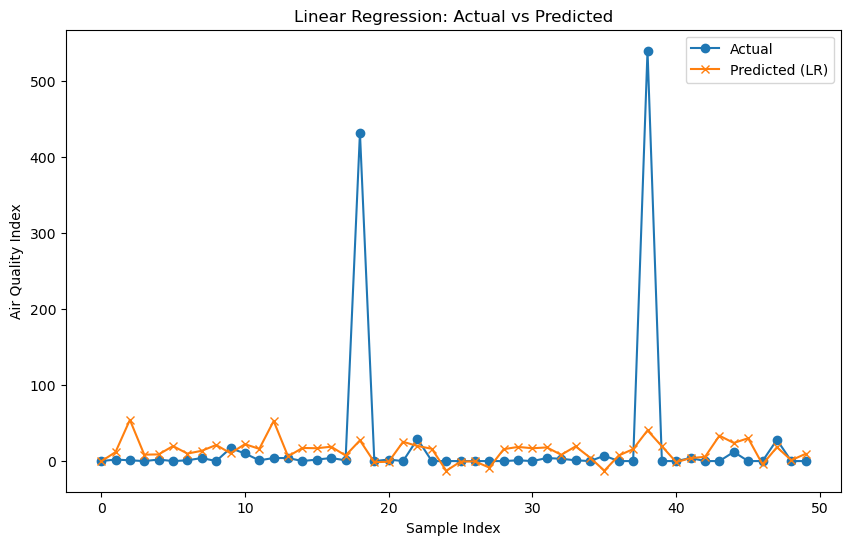

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:50], label='Actual', marker='o')
plt.plot(y_pred_lr[:50], label='Predicted (LR)', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Air Quality Index')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.show()

### Random Forest Regressor

In [24]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"MSE: {mse_rf:.2f}")
print(f"R²:  {r2_rf:.3f}")

MSE: 5883.62
R²:  0.336


In [25]:
# --- Gradient Boosting Regressor ---
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
print("\n--- Gradient Boosting Regressor ---")
print(f"MSE: {mse_gb:.2f}")
print(f"R²:  {r2_gb:.3f}")


--- Gradient Boosting Regressor ---
MSE: 6408.33
R²:  0.277


Epoch 1/50


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.1542e-04 - val_loss: 0.0654
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 4.6802e-04 - val_loss: 0.0641
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 6.1372e-04 - val_loss: 0.0649
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 5.5598e-04 - val_loss: 0.0641
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 4.7330e-04 - val_loss: 0.0637
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1343e-04 - val_loss: 0.0643
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 5.6238e-04 - val_loss: 0.0648
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - loss: 9.7699e-04 - val_loss: 0.0644
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 6.8115e-04 - val_loss: 0.0657
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 6.2304e-04 - val_loss: 0.0654
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - loss: 7.5976e-04 - val_loss: 0.0643
Epoch 12/50
67/67 ━━━━━

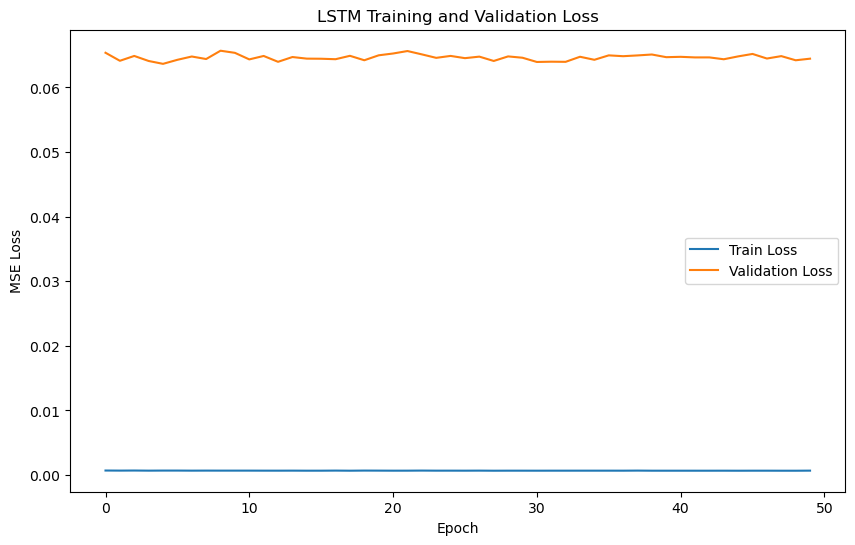

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


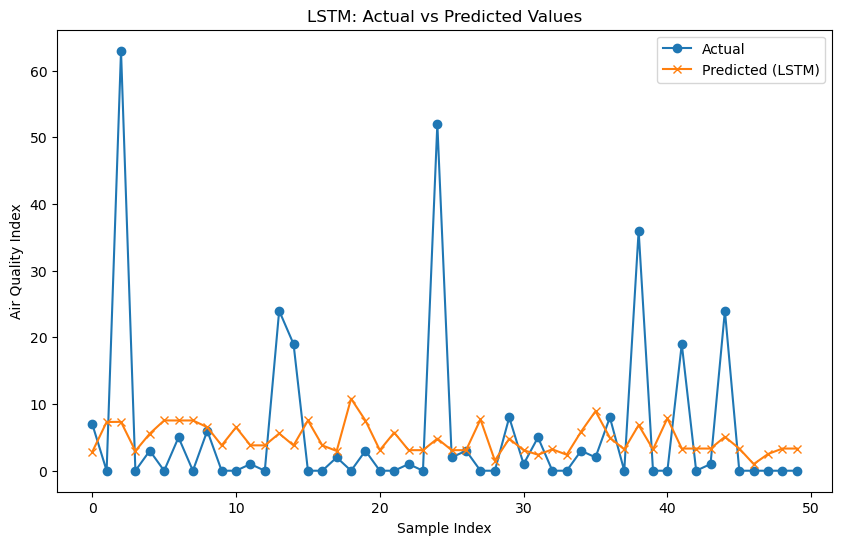

In [26]:
# --- LSTM Model ---
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_normalized = scaler_X.fit_transform(X)
y_normalized = scaler_y.fit_transform(y.values.reshape(-1, 1))

X_time_series = np.expand_dims(X_normalized, axis=1)

train_size_ts = int(0.8 * len(X_time_series))
X_train_ts = X_time_series[:train_size_ts]
X_test_ts = X_time_series[train_size_ts:]
y_train_ts = y_normalized[:train_size_ts]
y_test_ts = y_normalized[train_size_ts:]

lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_ts.shape[1], X_train_ts.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history_lstm = lstm_model.fit(
    X_train_ts, y_train_ts,
    epochs=50,
    batch_size=16,
    validation_data=(X_test_ts, y_test_ts),
    verbose=1
)

# Plot Training and Validation Loss for LSTM
plt.figure(figsize=(10, 6))
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('LSTM Training and Validation Loss')
plt.legend()
plt.show()

lstm_predictions = lstm_model.predict(X_test_ts)
lstm_predictions_rescaled = scaler_y.inverse_transform(lstm_predictions)
y_test_rescaled = scaler_y.inverse_transform(y_test_ts)

# Plot Actual vs Predicted Values for LSTM Model
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled[:50], label='Actual', marker='o')
plt.plot(lstm_predictions_rescaled[:50], label='Predicted (LSTM)', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Air Quality Index')
plt.title('LSTM: Actual vs Predicted Values')
plt.legend()
plt.show()

In [29]:
# Copy only test set portion
df_test = df.iloc[train_size_ts:].copy()  

# Add predictions to the DataFrame
df_test['Predicted AQI'] = lstm_predictions_rescaled

# Save to CSV
df_test.to_csv('lstm_predictions.csv', index=False)